<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/riset_prediksi_listrik_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [23]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
import pandas as pd
url_tr = 'https://drive.google.com/file/d/1jI7ukSaRReUFAUMeH2jDMJRhRd7AnWtk/view?usp=sharing'
path_tr = 'https://drive.google.com/uc?export=download&id='+url_tr.split('/')[-2]
train = pd.read_csv(path_tr)
url_tst = 'https://drive.google.com/file/d/1Wu56Cp5qDX9gPoPk5k5_zUTmV9u27aO-/view?usp=sharing'
path_tst = 'https://drive.google.com/uc?export=download&id='+url_tst.split('/')[-2]
test = pd.read_csv(path_tst)

In [24]:
import pandas as pd
df = pd.read_csv('/content/opsd_germany_daily.csv')

In [25]:
df = df[['Date','Consumption']]
df['Date'] = pd.to_datetime(df['Date'])


In [26]:
df.set_index(df['Date'],inplace=True)
df=df.drop(['Date'],axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  4383 non-null   float64
dtypes: float64(1)
memory usage: 68.5 KB


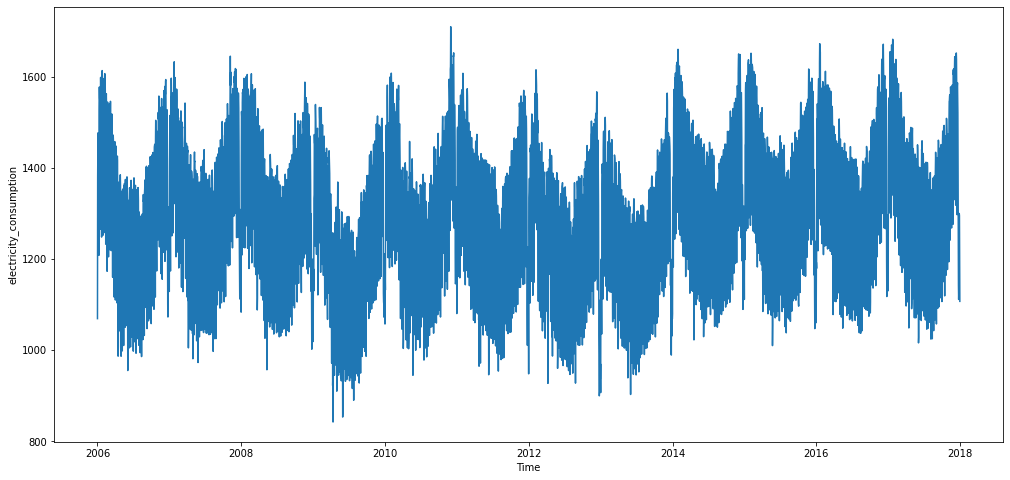

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(df['Consumption'])
plt.xlabel('Time')
plt.ylabel('electricity_consumption')
plt.grid(False)
plt.show()

In [41]:
from sklearn.preprocessing import minmax_scale
scaler = minmax_scale(df['Consumption'].values)

In [42]:
df['Consumption'] = scaler

In [43]:
split_time = 4353 
x_train = df[:split_time]
x_valid = df[split_time:]

window_size = 30
batch_size = 16
shuffle_buffer_size = 200


In [44]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [45]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(4353, 1)
Epoch 1/100
17/17 [==============================] - 3s 35ms/step - loss: 1330.6007 - mae: 1331.1007
Epoch 2/100
17/17 [==============================] - 1s 37ms/step - loss: 1331.1102 - mae: 1331.6102
Epoch 3/100
17/17 [==============================] - 1s 35ms/step - loss: 1330.7835 - mae: 1331.2835
Epoch 4/100
17/17 [==============================] - 1s 38ms/step - loss: 1330.9566 - mae: 1331.4566
Epoch 5/100
17/17 [==============================] - 1s 37ms/step - loss: 1330.3383 - mae: 1330.8383
Epoch 6/100
17/17 [==============================] - 1s 38ms/step - loss: 1331.1568 - mae: 1331.6568
Epoch 7/100
17/17 [==============================] - 1s 37ms/step - loss: 1330.6377 - mae: 1331.1377
Epoch 8/100
17/17 [==============================] - 1s 35ms/step - loss: 1330.7961 - mae: 1331.2961
Epoch 9/100
17/17 [==============================] - 1s 36ms/step - loss: 1330.614

(1e-08, 0.0001, 0.0, 2000.0)

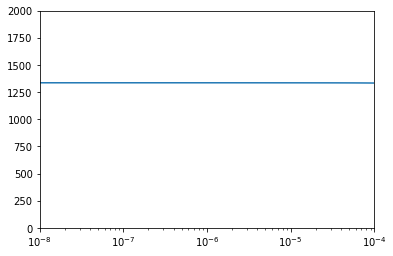

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 2000])

In [46]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=32, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='mae', factor=0.2, patience=3, min_lr=0.0001
)
early = tf.keras.callbacks.EarlyStopping(
    monitor='mae', patience=6, mode='auto'
)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(train_set,epochs=1000,callbacks=[reduce_lr,early])


Epoch 1/1000
136/136 [==============================] - 4s 8ms/step - loss: 0.0518 - mae: 0.2525
Epoch 2/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0138 - mae: 0.1360
Epoch 3/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0092 - mae: 0.1085
Epoch 4/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0065 - mae: 0.0861
Epoch 5/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0045 - mae: 0.0625
Epoch 6/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0040 - mae: 0.0578
Epoch 7/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0038 - mae: 0.0556
Epoch 8/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0036 - mae: 0.0539
Epoch 9/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0035 - mae: 0.0524
Epoch 10/1000
136/136 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0504
Epoch 11/1000
136/136 [======

In [48]:
mae = history.history['mae']
loss = history.history['loss']
epoch = range(len(history.history['mae']))

zoomed_mae = mae[-10:]
zoomed_loss = loss[-10:]
zoomed_epoch = epoch[-10:]

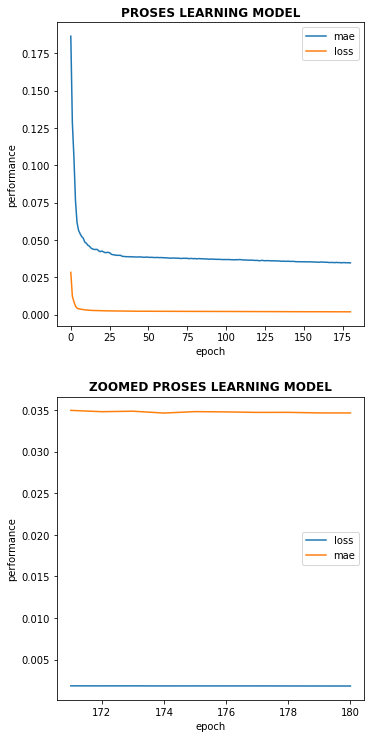

In [49]:
fig, ax = plt.subplots(figsize=(5,10), nrows=2)
plt.tight_layout(h_pad=5)
ax[0].plot(epoch, mae, label='mae')
ax[0].plot(epoch, loss, label='loss')
ax[0].legend()
ax[0].set_title('PROSES LEARNING MODEL', fontweight='bold')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('performance')

ax[1].plot(zoomed_epoch, zoomed_loss, label='loss')
ax[1].plot(zoomed_epoch, zoomed_mae, label='mae')
ax[1].legend()
ax[1].set_title('ZOOMED PROSES LEARNING MODEL', fontweight='bold')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('performance')
plt.show()

In [52]:
rnn_forecast = model_forecast(model, df[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

KeyError: ignored

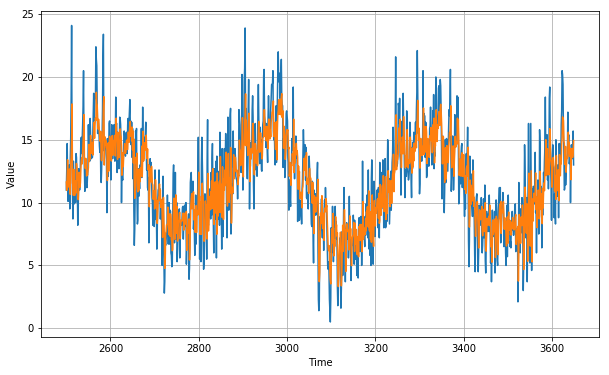

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

NameError: ignored

In [ ]:
print(rnn_forecast)

[11.636601 10.97607  12.159701 ... 13.589686 13.726407 14.940471]
